In [1]:
##**This notebook has two output csv files as of 6-02-25.  One for handling the imbalanced data with SMOTE and one without SMOTE**
## Reason for this is because I want to test without smote and using class weights penalties with Keras so see if I get
## better results.

import pandas as pd

files = ['input.csv', 'output.csv', 'loan_data.csv']
for fn in files:
    path = f'../data/{fn}'     # note the ../ to go up one directory
    df = pd.read_csv(path)
    print(f"{fn}: {df.shape}")
    display(df.head())





input.csv: (9577, 18)


,1,0.1189,829.1,11.35040654,19.48,737,5639.958333,28854,52.1,0,0.1,0.2,0.3,0.4,1.1,0.5,0.6,0.7
0,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0
1,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0
2,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0
3,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0
4,1,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,0,0,1,0,0,0,0


output.csv: (9577, 2)


,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


loan_data.csv: (9578, 14)


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [2]:
# 1. Inspect structure & missing values
df = pd.read_csv('../data/loan_data.csv')
df.info()

# 2. Quick summary stats
df.describe()

# 3. Examine the target balance
print(df['not.fully.paid'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
not.fully.paid
0    0.839946
1    0.160054
Name: proportion, dt

In [3]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


In [4]:
df['purpose'].value_counts()

purpose
debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: count, dtype: int64

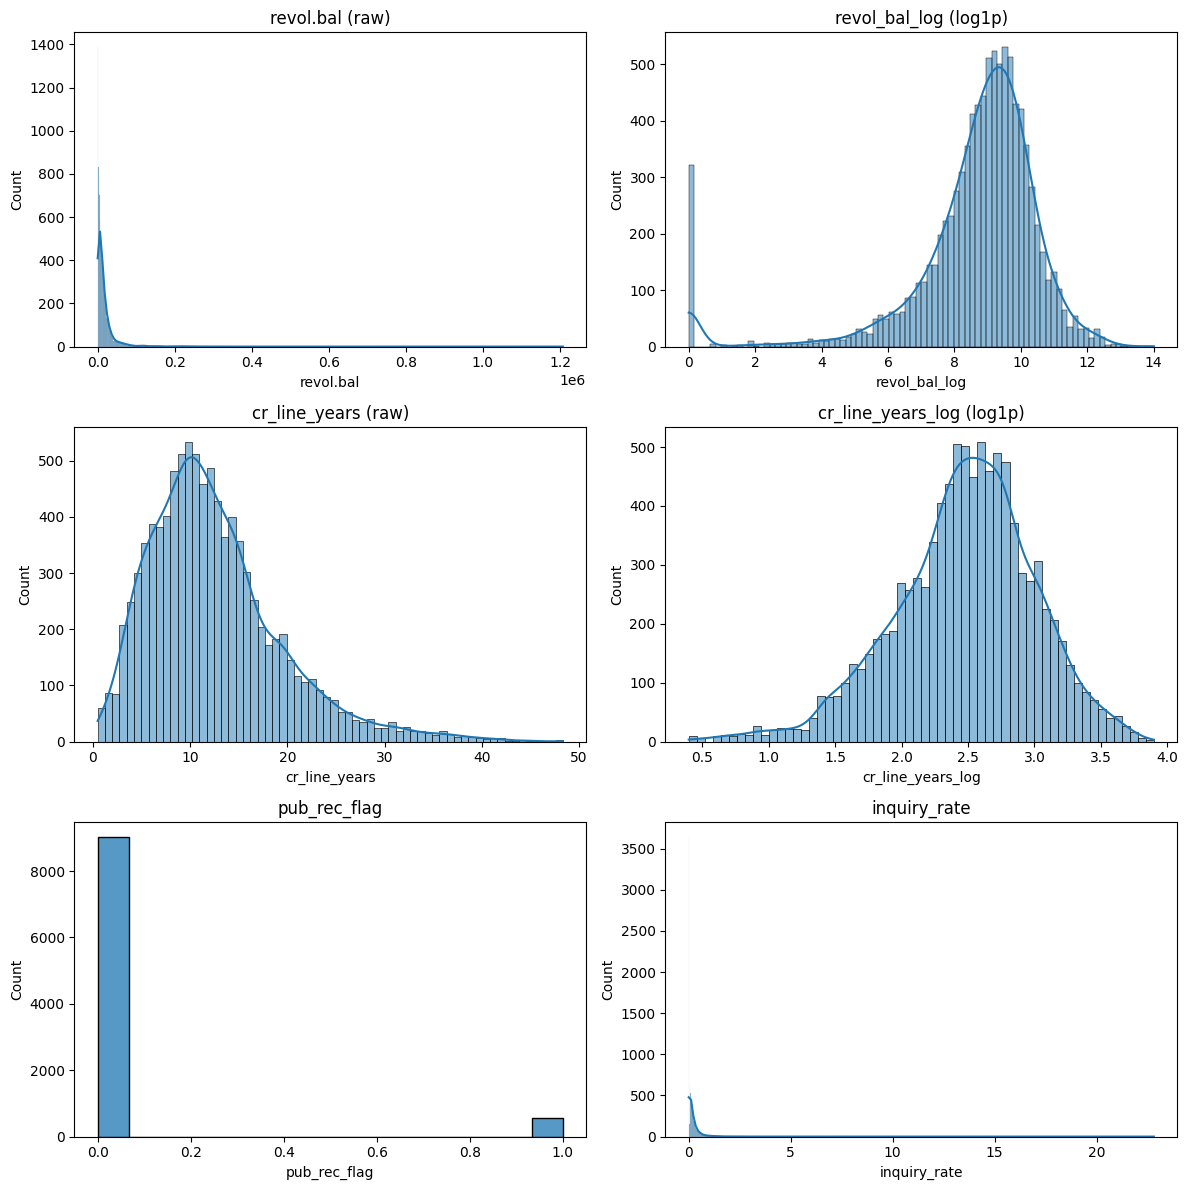

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create engineered columns
df['revol_bal_log']     = np.log1p(df['revol.bal'])
df['cr_line_years']     = df['days.with.cr.line'] / 365
df['cr_line_years_log'] = np.log1p(df['cr_line_years'])
df['pub_rec_flag']      = (df['pub.rec'] > 0).astype(int)
df['inquiry_rate']      = df['inq.last.6mths'] / df['cr_line_years']

# 2. Plot distributions before/after and of new features
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Raw vs log revol.bal
sns.histplot(df['revol.bal'], ax=axes[0,0], kde=True)
axes[0,0].set_title('revol.bal (raw)')
sns.histplot(df['revol_bal_log'], ax=axes[0,1], kde=True)
axes[0,1].set_title('revol_bal_log (log1p)')

# Raw vs log credit-line years
sns.histplot(df['cr_line_years'], ax=axes[1,0], kde=True)
axes[1,0].set_title('cr_line_years (raw)')
sns.histplot(df['cr_line_years_log'], ax=axes[1,1], kde=True)
axes[1,1].set_title('cr_line_years_log (log1p)')

# New engineered features
sns.histplot(df['pub_rec_flag'], ax=axes[2,0], kde=False)
axes[2,0].set_title('pub_rec_flag')
sns.histplot(df['inquiry_rate'], ax=axes[2,1], kde=True)
axes[2,1].set_title('inquiry_rate')

plt.tight_layout()
plt.show()



In [6]:
print("Raw revol.bal skew:", df['revol.bal'].skew())
print("Log revol.bal skew:", df['revol_bal_log'].skew())
print("Raw cr_line_years skew:", df['cr_line_years'].skew())
print("Log cr_line_years skew:", df['cr_line_years_log'].skew())
# huge positive skews (>1) dropped to small negative values (near symmetric)

Raw revol.bal skew: 11.161058494625456
Log revol.bal skew: -2.213951128118913
Raw cr_line_years skew: 1.1557482270969544
Log cr_line_years skew: -0.48603726603876085


In [7]:
from sklearn.preprocessing import StandardScaler

# List the numeric columns to scale
num_cols = [
    'revol_bal_log',
    'cr_line_years_log',
    'int.rate',
    'installment',
    'log.annual.inc',
    'dti',
    'fico',
    'revol.util',
    'inq.last.6mths',
    'delinq.2yrs',
    'pub.rec',
    'inquiry_rate'
]

# Initialize scaler and fit_transform on the entire df for now
# (In practice, we'll do train/test split first—but for EDA/demo we can scale everything)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Quick sanity check: all means ~0, stds ~1
df[num_cols].describe().loc[['mean','std']].T



,mean,std
revol_bal_log,3.827940e-16,1.000052
cr_line_years_log,7.774575e-16,1.000052
int.rate,-4.747832e-17,1.000052
installment,-4.896202e-17,1.000052
log.annual.inc,1.348681e-15,1.000052
dti,-7.121748e-17,1.000052
fico,2.848699e-16,1.000052
revol.util,4.154353e-17,1.000052
inq.last.6mths,2.373916e-17,1.000052
delinq.2yrs,1.186958e-17,1.000052


In [8]:
# One-hot encode purpose, drop the first category to avoid multicollinearity
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

# Check new columns
[p for p in df.columns if p.startswith('purpose_')]


['purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_major_purchase',
 'purpose_small_business']

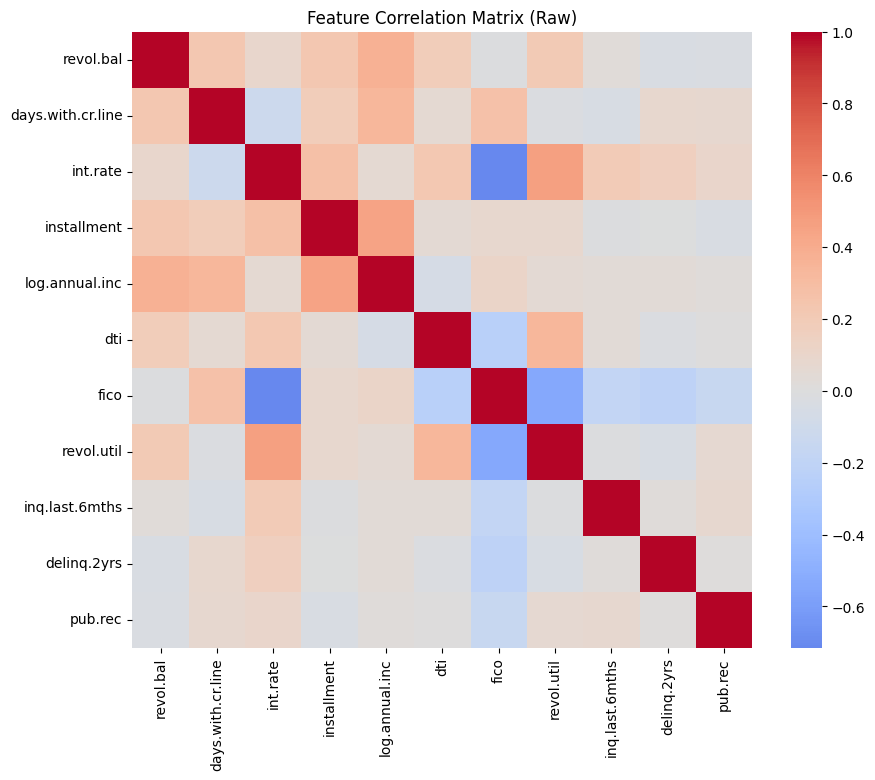

Highly correlated pairs (|r| > 0.8):
 Series([], dtype: float64)


In [11]:
# — Correlation Analysis —  
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0) Load loan_data.csv explicitly 
df_raw = pd.read_csv('../data/loan_data.csv')

# 1) Pick numeric + engineered (you’ll engineer these next)
corr_cols = [
    'revol.bal', 'days.with.cr.line',
    'int.rate', 'installment', 'log.annual.inc',
    'dti', 'fico', 'revol.util',
    'inq.last.6mths', 'delinq.2yrs', 'pub.rec'
]
corr = df_raw[corr_cols].corr()

# 2) Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix (Raw)")
plt.show()

# 3) List high-correlation pairs
high_corr = (
    corr.abs()
        .where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .loc[lambda x: x > 0.8]
        .sort_values(ascending=False)
)
print("Highly correlated pairs (|r| > 0.8):\n", high_corr)



In [12]:
# In your EDA notebook, below the correlation cell:
df_clean = pd.read_csv('../data/loan_data.csv')

# Engineer the same features as before:
df_clean['cr_line_years'] = df_clean['days.with.cr.line'] / 365
df_clean['pub_rec_flag']  = (df_clean['pub.rec'] > 0).astype(int)
df_clean['inquiry_rate']  = df_clean['inq.last.6mths'] / df_clean['cr_line_years']
df_clean = pd.get_dummies(df_clean, columns=['purpose'], drop_first=True)
df_clean = df_clean.drop(columns=['revol.bal', 'days.with.cr.line'])

# Scale numeric columns:
from sklearn.preprocessing import StandardScaler
num_cols = [
    'int.rate','installment','log.annual.inc','dti','fico',
    'revol.util','inq.last.6mths','delinq.2yrs','pub.rec',
    'cr_line_years','inquiry_rate'
]
scaler = StandardScaler().fit(df_clean[num_cols])
df_clean[num_cols] = scaler.transform(df_clean[num_cols])

# Save clean CSV
df_clean.to_csv('../data/loan_data_ready_clean.csv', index=False)


In [1]:
# **** Do-over this time transforming the csv differently to see if I get different results with same model *****
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # 1. Reload true raw data (unmodified loan_data.csv)
# df_raw = pd.read_csv('../data/loan_data.csv')

# # 2. Engineer features (except log‐transforms)
# df_raw['cr_line_years'] = df_raw['days.with.cr.line'] / 365
# df_raw['pub_rec_flag']  = (df_raw['pub.rec'] > 0).astype(int)
# df_raw['inquiry_rate']  = df_raw['inq.last.6mths'] / df_raw['cr_line_years']

# # 3. One‐hot encode 'purpose'
# df_raw = pd.get_dummies(df_raw, columns=['purpose'], drop_first=True)

# # 4. Drop the raw skewed columns (we want to keep them un‐logged but scaled)

# df_raw = df_raw.drop(columns=['revol.bal', 'days.with.cr.line'])

# # 5. Standard‐scale numeric features (no log columns here):
# num_cols_raw = [
#     'int.rate',
#     'installment',
#     'log.annual.inc',
#     'dti',
#     'fico',
#     'revol.util',
#     'inq.last.6mths',
#     'delinq.2yrs',
#     'pub.rec',
#     'cr_line_years',
#     'inquiry_rate'
# ]



# scaler = StandardScaler().fit(df_raw[num_cols_raw])
# df_raw[num_cols_raw] = scaler.transform(df_raw[num_cols_raw])

# # 6. Save as a new CSV variant
# df_raw.to_csv('../data/loan_data_ready_raw.csv', index=False)

# # 7. Quick verification
# print("Columns in df_raw:", df_raw.columns.tolist())
# print("Sample scaled stats:\n", df_raw[num_cols_raw].describe().loc[['mean','std']].T)



Columns in df_raw: ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid', 'cr_line_years', 'pub_rec_flag', 'inquiry_rate', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']
Sample scaled stats:
                         mean       std
int.rate       -4.747832e-17  1.000052
installment    -4.896202e-17  1.000052
log.annual.inc  1.348681e-15  1.000052
dti            -7.121748e-17  1.000052
fico            2.848699e-16  1.000052
revol.util      4.154353e-17  1.000052
inq.last.6mths  2.373916e-17  1.000052
delinq.2yrs     1.186958e-17  1.000052
pub.rec         5.638051e-17  1.000052
cr_line_years  -6.528269e-17  1.000052
inquiry_rate    0.000000e+00  1.000052


Numeric feature correlations with default-rate:
 int.rate             0.159552
fico                -0.149666
inq.last.6mths       0.149452
revol.util           0.082088
revol.bal            0.053699
installment          0.049955
pub.rec              0.048634
dti                  0.037362
log.annual.inc      -0.033439
days.with.cr.line   -0.029237
delinq.2yrs          0.008881
Name: not.fully.paid, dtype: float64


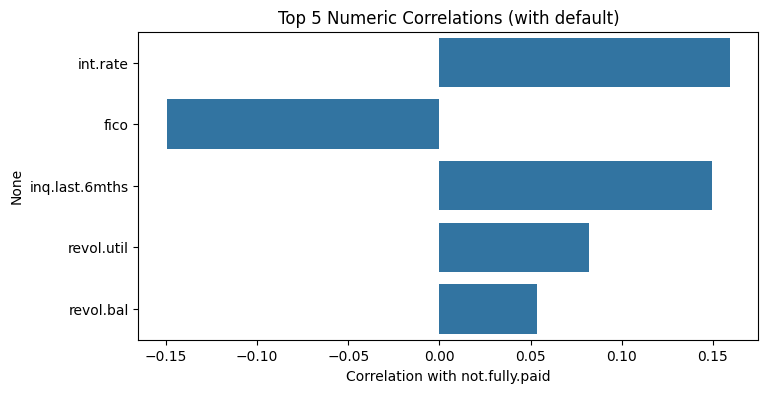


Default rate by purpose:
 purpose
small_business        0.277868
educational           0.201166
home_improvement      0.170111
all_other             0.166023
debt_consolidation    0.152388
credit_card           0.115689
major_purchase        0.112128
Name: not.fully.paid, dtype: float64


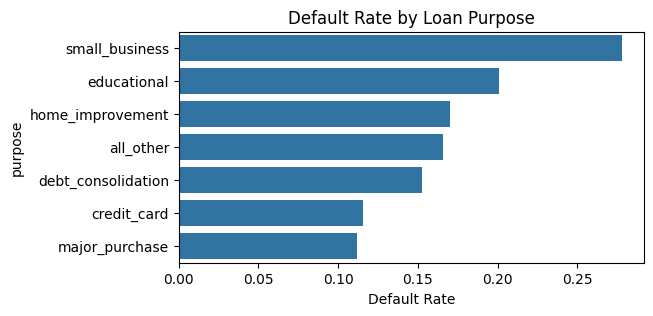


Mutual information scores:
 int.rate             0.015327
inq.last.6mths       0.012557
fico                 0.010013
days.with.cr.line    0.007770
installment          0.006757
revol.util           0.005266
revol.bal            0.004424
log.annual.inc       0.003739
dti                  0.002608
pub.rec              0.001014
delinq.2yrs          0.000000
dtype: float64


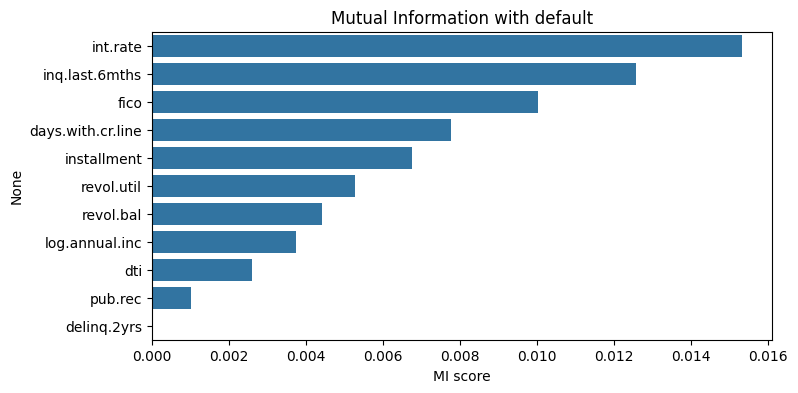

In [13]:
# — Univariate Feature Importance on Raw Data —  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# 1) Reload raw loan_data  
df = pd.read_csv('../data/loan_data.csv')

# 2) Numeric correlations (point-biserial) with the binary target  
num_cols = [
    'int.rate','installment','log.annual.inc','dti','fico',
    'days.with.cr.line','revol.bal','revol.util',
    'inq.last.6mths','delinq.2yrs','pub.rec'
]
corr_with_target = df[num_cols + ['not.fully.paid']].corr()['not.fully.paid'] \
                        .drop('not.fully.paid') \
                        .sort_values(key=lambda x: x.abs(), ascending=False)
print("Numeric feature correlations with default-rate:\n", corr_with_target)

# 3) Plot the top-5 absolute correlations  
top5 = corr_with_target.abs().nlargest(5).index
plt.figure(figsize=(8,4))
sns.barplot(x=corr_with_target[top5].values, y=top5)
plt.title("Top 5 Numeric Correlations (with default)")
plt.xlabel("Correlation with not.fully.paid")
plt.show()

# 4) Categorical default rates for 'purpose'  
p = df.groupby('purpose')['not.fully.paid'].mean().sort_values(ascending=False)
print("\nDefault rate by purpose:\n", p)
plt.figure(figsize=(6,3))
sns.barplot(x=p.values, y=p.index)
plt.title("Default Rate by Loan Purpose")
plt.xlabel("Default Rate")
plt.show()

# 5) Mutual information to catch non-linear effects  
X = df[num_cols].fillna(0)
y = df['not.fully.paid']
mi = pd.Series(mutual_info_classif(X, y, discrete_features=False, random_state=42),
               index=num_cols).sort_values(ascending=False)
print("\nMutual information scores:\n", mi)

# 6) Plot MI  
plt.figure(figsize=(8,4))
sns.barplot(x=mi.values, y=mi.index)
plt.title("Mutual Information with default")
plt.xlabel("MI score")
plt.show()


/var/folders/_w/1v5jxkz56qxcjphx0msmcxr00000gn/T/ipykernel_60451/1283454599.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_rates = df.groupby('fico_band')['not.fully.paid'].mean().dropna()


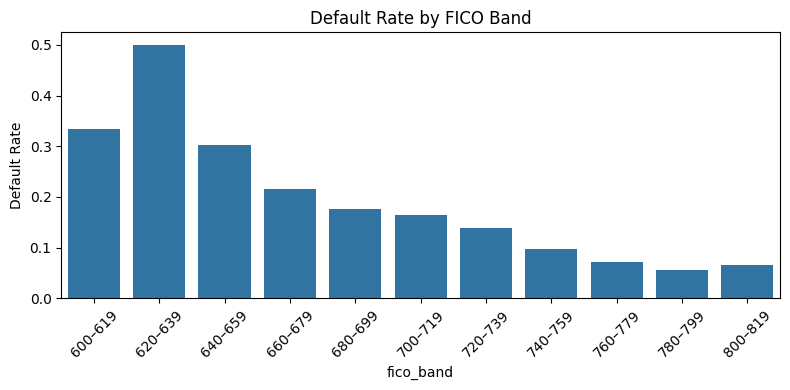

In [16]:
# — Default Rate by FICO Band —
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/loan_data.csv')

# Create FICO bands of size 20 (e.g. 600–620, 620–640, …)
bins = list(range(600, 821, 20))
labels = [f"{b}–{b+19}" for b in bins[:-1]]
df['fico_band'] = pd.cut(df['fico'], bins=bins, labels=labels, right=False)

# Compute default rate per band
band_rates = df.groupby('fico_band')['not.fully.paid'].mean().dropna()

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=band_rates.index, y=band_rates.values)
plt.xticks(rotation=45)
plt.ylabel("Default Rate")
plt.title("Default Rate by FICO Band")
plt.tight_layout()
plt.show()


In [17]:
# — Build FICO + Interest-Rate CSV —

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Reload raw
df2 = pd.read_csv('../data/loan_data.csv')

# 2) Select only fico and int.rate plus target
keep = ['fico', 'int.rate', 'not.fully.paid']
df2 = df2[keep]

# 3) Scale both features
scaler2 = StandardScaler().fit(df2[['fico','int.rate']])
df2[['fico','int.rate']] = scaler2.transform(df2[['fico','int.rate']])

# 4) Save
df2.to_csv('../data/loan_data_ready_fico_ir.csv', index=False)
print("Columns in two-feature CSV:", df2.columns.tolist())


Columns in two-feature CSV: ['fico', 'int.rate', 'not.fully.paid']


In [18]:
# — Build FICO + Int.Rate + Inquiries CSV —

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Reload raw data
df3 = pd.read_csv('../data/loan_data.csv')

# 2) Keep only our three features + target
keep3 = ['fico', 'int.rate', 'inq.last.6mths', 'not.fully.paid']
df3 = df3[keep3]

# 3) Scale the numeric features
scaler3 = StandardScaler().fit(df3[['fico','int.rate','inq.last.6mths']])
df3[['fico','int.rate','inq.last.6mths']] = scaler3.transform(
    df3[['fico','int.rate','inq.last.6mths']]
)

# 4) Save this CSV
df3.to_csv('../data/loan_data_ready_fico_ir_inq.csv', index=False)
print("Three-feature CSV saved. Columns:", df3.columns.tolist())


Three-feature CSV saved. Columns: ['fico', 'int.rate', 'inq.last.6mths', 'not.fully.paid']


In [15]:
# — Build Minimal Feature CSV —

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Reload raw data
df_min = pd.read_csv('../data/loan_data.csv')

# 2) Select the top numeric features
top_nums = ['int.rate', 'inq.last.6mths', 'fico']

# 3) Create explicit flags for the two high-risk purposes
df_min['small_business_flag'] = (df_min['purpose'] == 'small_business').astype(int)
df_min['educational_flag']    = (df_min['purpose'] == 'educational').astype(int)

# 4) Keep only the features we want + target
keep = top_nums + ['small_business_flag', 'educational_flag', 'not.fully.paid']
df_min = df_min[keep]

# 5) Scale numeric columns
scaler_min = StandardScaler().fit(df_min[top_nums])
df_min[top_nums] = scaler_min.transform(df_min[top_nums])

# 6) Save
df_min.to_csv('../data/loan_data_ready_minimal.csv', index=False)
print("Minimal CSV saved with columns:", df_min.columns.tolist())



Minimal CSV saved with columns: ['int.rate', 'inq.last.6mths', 'fico', 'small_business_flag', 'educational_flag', 'not.fully.paid']
